In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D Plotting of Systems
import pandas as pd
from sympy import diff
from scipy import integrate
import scipy as sp
import traceback
%matplotlib inline

In [88]:
def f_int(t, x, z):
    a, b, c, d, e, f = np.polyfit(x, z, 5)
    return(-t**2 * (5*a*t**4 + 4*b*t**3 + 3*c*t**2 + 2*d*t + e))

In [89]:
def volume_calc(x, z):
    mi = min(x)
    ma = max(x)
    v, err = integrate.quad(f_int, mi, ma, args = (x, z))
    return np.pi*v
    

In [90]:
#Runge-Kutta Method Single Time Step
def rk4(func, t, a, b, c, dt, b_k):
    """
    Peforms a single time step of the Runge-Kutta 4th Order Method.
    The below function finds the ki value for [dx,dy,dz] and return the value to move Yn+1
    func is an input of functions, for the Lorenz system this is [dx,dy,dz]
     
    Recall Rk4 Equations :
    k1 = h*f(xn,yn)
    k2 = h*f(xn+h/2,yn+k1/2)
    k3 = h*f(xn+h/2,yn+k2/2) 
    k4 = h*f(xn,yn+k3)
    Where f is a function [dx,dy,dz]
    Yn+1 = Yn + 1/6*(k1+k2+k3+k4)
    """
    
    k1, k2, k3, k4 = [], [], [], []
    
    for f in func:
        k1.append(dt*f(t, a, b, c, b_k))
        
    for f in func:
        k2.append(dt*f(t+dt/2, a+k1[0]/2, b+k1[1]/2, c+k1[2]/2, b_k))
        
    for f in func:
        k3.append(dt*f(t+dt/2, a+k2[0]/2, b+k2[1]/2, c+k2[2]/2, b_k))
        
    for f in func:
        k4.append( dt*f(t+dt, a+k3[0], b+k3[1], c+k3[1], b_k))
        
    k1, k2, k3, k4 = np.array(k1), np.array(k2), np.array(k3), np.array(k4)
    
    return (1/6)*(k1+2*k2+2*k3+k4)

In [91]:
#function, which calculate error for each c value and finds optipal value

In [92]:
# Constants 

# c = 10*1000/0.073


#b - radios od curvation 
#c - capillar const

#dx, df, dx for equtions, which determine form of the drop
def dx(t, x, fi, z, b):
    return np.cos(fi)

def dfi(t, x, fi, z, b):
    return 2*b-z-np.sin(fi)/(x+1e-5)

def dz(t, x, fi, z, b):
    return -np.sin(fi)

In [93]:
def Laplas(x0, fi0, z0, start_time, time_step, b, t_max):

    x, fi, z = [x0], [fi0], [z0] # Start Points
    count = 0
#     t = start_time or 0 # Start Time
#     dt = time_step or 0.01 # Time Step
    t = start_time  # Start Time
    dt = time_step  # Time Step
    
    while t < t_max:
        t+= dt
        tempx, tempfi, tempz = x[count], fi[count], z[count] # Temporary Start Points
        func = np.array([dx, dfi, dz])
        
        runge_kutta_4 = rk4(func, t, tempx, tempfi, tempz, dt, b) # Rk4 Function
        
        tempx += runge_kutta_4[0]
        tempfi += runge_kutta_4[1]
        tempz += runge_kutta_4[2]
        count +=1
        
        x.append(tempx)
        fi.append(tempfi)
        z.append(tempz)  
    return x, fi, z

In [94]:
#adress to Laplas function and then finds the polyfit approximation of the curve 
def graf(b, t_max):


    np.seterr(all='warn')
    x, fi, z = Laplas(0, 0, 0, 0, 0.01, b, t_max)

    t = np.linspace(0, 1.6, len(z))

    a, b, c, d, e, f = np.polyfit(x, z, 5)

    xx = np.arange(min(x), max(x), 0.01)
    yy = a*xx**5 + b*xx**4 + c*xx**3 + d*xx**2 + e*xx + f

#     plt.plot(xx, yy)
#     print(V)
    return (x, fi, z)



In [95]:
#finds current angle with diff
def angle(x, y):
    return np.arctan(np.diff(y)/np.diff(x))

In [96]:
#determine contact angle
def angl_exp(x1, y1):
    ln = len(x1)
    atan = np.arctan(diff(y1.loc[ln-30:ln-1])/diff(x1.loc[ln-30:ln-1])).dropna().reset_index(drop=True)
    return np.mean(atan), x1.loc[ln-1]/y1.loc[ln-1]

In [11]:
#finds x, z, which angle is equal to experimental
def finds_angle(agl, experim_angl):
    
    for i in range(1, len(agl)):
        if abs(agl[i])>abs(experim_angl):
            return i

In [12]:
#returns the index of the last element, before the shape becomes spiral
def find_cut_ind(agl):
    dif_agl = np.diff(agl)
    dt = list(filter(lambda x: x>0, dif_agl))
    plt.plot(dif_agl)
    a = (list(dif_agl).index(dt[0]))
    return a

In [13]:
#finds approximate value of b, using coefficient table 
def finds_b_approx(ct_angl, rat, coef_tbl, acur_rel, acur_rel_xz):
    
    df_agl = pd.DataFrame()
    acur_abs = ct_angl*acur_rel
    
    for j in range(len(coef_tbl)):
        if abs(coef_tbl['angle'].loc[j])<abs(ct_angl+acur_abs) and abs(coef_tbl['angle'].loc[j])>abs(ct_angl-acur_abs):
            df_agl = df_agl.append(coef_tbl.loc[j], ignore_index = True)

    acur_abs_xz = (acur_rel_xz*rat)
    df_fin = pd.DataFrame()
    
    for j in range(len(df_agl)):
        if abs(df_agl['x/z'].loc[j])<abs(rat+acur_abs_xz) and abs(df_agl['x/z'].loc[j])>abs(rat-acur_abs_xz):
            df_fin = df_fin.append(df_agl.loc[j], ignore_index = True)
    return df_fin

In [14]:
#function which normalize experimental data 
def normalize(x1, y1, z_ap):
    x2 = z_ap[len(z_ap)-1]*x1/y1.loc[len(y1)-1]
    y2 = z_ap[len(z_ap)-1]*y1/y1.loc[len(y1)-1]
    return x2, y2

In [83]:
#finds distance between exp and theor curves
def distance(b_i, T, x2, y2):
    x_ap, fi, z_ap = graf(b_i, T)
    
    x_ap = np.array(x_ap)
    z_ap = np.array(z_ap)
    
    x_ap_new =[]
    z_ap_new = []
    print(x_ap[0])
    for j in range(len(x2)):
        df_c = []
        for i in range(len(x_ap)):
            df_c.append(abs(np.array(x2)[j]-x_ap[i]))
        ind = df_c.index(min(df_c))
        x_ap_new.append(x_ap[ind])
        z_ap_new.append(z_ap[ind])    

    dist = []

    for n in range(len(x2)):
        x2_i = np.array(x2)[n]
        y2_i = np.array(y2)[n]
        x_ap_i = x_ap_new[n]
        z_ap_i = z_ap_new[n]
        dist_i = ((x_ap_i - x2_i)**2 + (z_ap_i - y2_i)**2)
        dist.append(dist_i)

    dist_v = sum(dist)/len(dist)
    
    return dist_v

In [ ]:
def surf_ten(z_pr, y1):
    H_th = max(z_pr) - min(z_pr)
    H_exp = 0.000788
    c = (H_th/H_exp)**2
    return 10**4/c

In [ ]:
#main function, which adress to other functions and receive the x, z and fi

b = 1
t_max = 15
x, fi, z = graf(b, t_max)


agl = angle(x, z)
plt.figure()
plt.plot(x, z)

plt.title("Numerical solution of Laplase equation")
plt.xlabel("x")
plt.ylabel("z")
plt.grid(linewidth = 0.35)

plt.figure()
plt.plot(x[0:-1], -agl*180/np.pi)



In [ ]:
coef_tbl = pd.read_csv('coef.csv')

  Main_Material  Main_Value Addition_Material Percent_of_Addition_Material  \
0         Water       200.0               alc                            1   
1          Glyc       300.0              none                            0   
2           NaN         NaN               NaN                            2   
3           NaN         NaN               NaN                          0p5   

   Attempt  Temperature  
0      1.0         23.0  
1      2.0         16.0  
2      3.0         26.0  
3      NaN          NaN  
200_Water_alc_1_1_23
    T_max  Unnamed: 0     angle    b       x/z
0    2.64       564.0 -1.128068  0.2 -2.363008
1    2.06       906.0 -1.002060  0.3 -2.361988
2    2.07       907.0 -1.011177  0.3 -2.343234
3    2.08       908.0 -1.020365  0.3 -2.324640
4    2.09       909.0 -1.029626  0.3 -2.306205
5    2.10       910.0 -1.038959  0.3 -2.287926
6    2.11       911.0 -1.048365  0.3 -2.269801
7    2.12       912.0 -1.057844  0.3 -2.251829
8    2.13       913.0 -1.067398  0.

200_Water_alc_1_3_23
    T_max  Unnamed: 0     angle    b       x/z
0    1.83      1283.0 -1.066998  0.4 -2.090259
1    1.84      1284.0 -1.076947  0.4 -2.072360
2    1.85      1285.0 -1.086970  0.4 -2.054630
3    1.86      1286.0 -1.097069  0.4 -2.037066
4    1.55      1655.0 -1.018208  0.5 -2.086913
5    1.56      1656.0 -1.028230  0.5 -2.067386
6    1.57      1657.0 -1.038323  0.5 -2.048074
7    1.58      1658.0 -1.048488  0.5 -2.028973
8    1.59      1659.0 -1.058725  0.5 -2.010080
9    1.60      1660.0 -1.069036  0.5 -1.991390
10   1.61      1661.0 -1.079420  0.5 -1.972900
11   1.62      1662.0 -1.089878  0.5 -1.954607
12   1.63      1663.0 -1.100411  0.5 -1.936506
13   1.34      2034.0 -0.986360  0.6 -2.085057
14   1.35      2035.0 -0.996690  0.6 -2.063691
15   1.36      2036.0 -1.007089  0.6 -2.042599
16   1.37      2037.0 -1.017557  0.6 -2.021774
17   1.38      2038.0 -1.028096  0.6 -2.001210
18   1.39      2039.0 -1.038706  0.6 -1.980903
19   1.40      2040.0 -1.049387  0.6 -1

200_Water_alc_2_1_23
    T_max  Unnamed: 0     angle    b       x/z
0    1.43      1243.0 -0.723827  0.4 -2.982454
1    1.19      1619.0 -0.700049  0.5 -2.977870
2    1.20      1620.0 -0.707885  0.5 -2.946727
3    1.21      1621.0 -0.715771  0.5 -2.916050
4    1.22      1622.0 -0.723709  0.5 -2.885829
5    1.01      2001.0 -0.680289  0.6 -2.996064
6    1.02      2002.0 -0.688674  0.6 -2.960697
7    1.03      2003.0 -0.697109  0.6 -2.925960
8    1.04      2004.0 -0.705595  0.6 -2.891835
9    1.05      2005.0 -0.714131  0.6 -2.858305
10   1.06      2006.0 -0.722718  0.6 -2.825353
1      0.003971
2      0.007942
3      0.011913
4      0.015884
5      0.019854
         ...   
220    0.869624
221    0.873595
222    0.877566
223    0.881537
224    0.885508
Name: x, Length: 224, dtype: float64
0.0
a
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


200_Water_alc_2_3_23
Empty DataFrame
Columns: []
Index: []
Ошибка:
 Traceback (most recent call last):
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1618, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1626, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-86-4c8b4f98348b>", line 61, in <module>
    B_ap = float(df_approx['b'].loc[len(df_approx)//2])
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\frame.py", line 2800, in __getitem__
    indexer = self.co

a
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.437329171133225
  Main_Material  Main_Value Addition_Material Percent_of_Addition_Material  \
0         Water         200               alc                          0p5   

   Attempt  Temperature       x/z    angle     b     Value     cap_const  \
0        2           23 -1.513514 -0.29791  0.35  4.437329  78957.690014   

      sigma  
0  0.124244  
Ошибка:
 Traceback (most recent call last):
  File "<ipython-input-86-4c8b4f98348b>", line 24, in <module>
    h = pd.read_csv(name + '.csv')
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\io\parsers.py", line 676, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\io\parsers.py", line 448, in _read
    parser = TextFileRea

200_Glyc_alc_1_1_23
   T_max  Unnamed: 0     angle    b       x/z
0   4.16       316.0  1.018409  0.1 -1.705878
1   4.17       317.0  1.001197  0.1 -1.694959
2   4.18       318.0  0.983875  0.1 -1.684149
3   4.19       319.0  0.966443  0.1 -1.673449
1      0.024566
2      0.049131
3      0.073697
4      0.098262
5      0.122828
         ...   
126    2.849605
127    2.874171
128    2.874171
129    2.898736
130    2.898736
Name: x, Length: 130, dtype: float64
0.0
a
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
13.63196662343777
  Main_Material  Main_Value Addition_Material  Percent_of_Addition_Material  \
0          Glyc         200               alc                             1   

   Attempt  Temperature       x/z     angle     b      Value     cap_const  \
0        1           23 -1.594595 -1

200_Glyc_alc_1_3_16
Empty DataFrame
Columns: []
Index: []
Ошибка:
 Traceback (most recent call last):
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1618, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1626, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-86-4c8b4f98348b>", line 61, in <module>
    B_ap = float(df_approx['b'].loc[len(df_approx)//2])
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\frame.py", line 2800, in __getitem__
    indexer = self.col

200_Glyc_alc_0_3_23
Empty DataFrame
Columns: []
Index: []
Ошибка:
 Traceback (most recent call last):
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1618, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1626, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-86-4c8b4f98348b>", line 61, in <module>
    B_ap = float(df_approx['b'].loc[len(df_approx)//2])
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\frame.py", line 2800, in __getitem__
    indexer = self.col

200_Glyc_alc_2_2_23
    T_max  Unnamed: 0     angle    b       x/z
0    4.08       308.0  1.152168  0.1 -1.797150
1    4.09       309.0  1.135830  0.1 -1.785360
2    4.10       310.0  1.119383  0.1 -1.773679
3    4.11       311.0  1.102828  0.1 -1.762107
4    4.12       312.0  1.086163  0.1 -1.750644
5    4.13       313.0  1.069389  0.1 -1.739289
6    4.14       314.0  1.052505  0.1 -1.728043
7    4.15       315.0  1.035512  0.1 -1.716906
8    1.91      1291.0 -1.148709  0.4 -1.951646
9    1.62      1662.0 -1.089878  0.5 -1.954607
10   1.63      1663.0 -1.100411  0.5 -1.936506
11   1.64      1664.0 -1.111020  0.5 -1.918595
12   1.65      1665.0 -1.121704  0.5 -1.900870
13   1.66      1666.0 -1.132466  0.5 -1.883328
14   1.67      1667.0 -1.143304  0.5 -1.865965
15   1.68      1668.0 -1.154221  0.5 -1.848779
16   1.40      2040.0 -1.049387  0.6 -1.960846
17   1.41      2041.0 -1.060140  0.6 -1.941035
18   1.42      2042.0 -1.070967  0.6 -1.921464
19   1.43      2043.0 -1.081866  0.6 -1.

200_Glyc_alc_0p5_1_23
    T_max  Unnamed: 0     angle    b       x/z
0    3.95       295.0  1.354741  0.1 -1.960363
1    3.96       296.0  1.339800  0.1 -1.947149
2    3.97       297.0  1.324752  0.1 -1.934046
3    3.98       298.0  1.309599  0.1 -1.921052
4    3.99       299.0  1.294339  0.1 -1.908169
5    2.90       590.0 -1.413108  0.2 -1.950058
6    2.91       591.0 -1.425270  0.2 -1.935684
7    2.92       592.0 -1.437526  0.2 -1.921414
8    2.93       593.0 -1.449876  0.2 -1.907247
9    2.94       594.0 -1.462321  0.2 -1.893183
10   2.95       595.0 -1.474862  0.2 -1.879221
11   2.34       934.0 -1.286157  0.3 -1.891512
12   2.35       935.0 -1.297485  0.3 -1.876587
13   2.36       936.0 -1.308901  0.3 -1.861777
14   2.37       937.0 -1.320404  0.3 -1.847082
15   2.38       938.0 -1.331995  0.3 -1.832499
16   2.39       939.0 -1.343675  0.3 -1.818029
17   2.40       940.0 -1.355445  0.3 -1.803670
18   2.41       941.0 -1.367305  0.3 -1.789420
19   2.42       942.0 -1.379255  0.3 -

200_Glyc_alc_0p5_3_23
Empty DataFrame
Columns: []
Index: []
Ошибка:
 Traceback (most recent call last):
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1618, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1626, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-86-4c8b4f98348b>", line 61, in <module>
    B_ap = float(df_approx['b'].loc[len(df_approx)//2])
  File "C:\Users\gorar\anaconda3\lib\site-packages\pandas\core\frame.py", line 2800, in __getitem__
    indexer = self.c

200_Glyc_none_0_2_26
    T_max  Unnamed: 0     angle    b       x/z
0    1.84      1284.0 -1.076947  0.4 -2.072360
1    1.85      1285.0 -1.086970  0.4 -2.054630
2    1.86      1286.0 -1.097069  0.4 -2.037066
3    1.87      1287.0 -1.107243  0.4 -2.019665
4    1.88      1288.0 -1.117494  0.4 -2.002425
5    1.89      1289.0 -1.127821  0.4 -1.985343
6    1.56      1656.0 -1.028230  0.5 -2.067386
7    1.57      1657.0 -1.038323  0.5 -2.048074
8    1.58      1658.0 -1.048488  0.5 -2.028973
9    1.59      1659.0 -1.058725  0.5 -2.010080
10   1.60      1660.0 -1.069036  0.5 -1.991390
11   1.61      1661.0 -1.079420  0.5 -1.972900
12   1.62      1662.0 -1.089878  0.5 -1.954607
13   1.63      1663.0 -1.100411  0.5 -1.936506
14   1.64      1664.0 -1.111020  0.5 -1.918595
15   1.65      1665.0 -1.121704  0.5 -1.900870
16   1.35      2035.0 -0.996690  0.6 -2.063691
17   1.36      2036.0 -1.007089  0.6 -2.042599
18   1.37      2037.0 -1.017557  0.6 -2.021774
19   1.38      2038.0 -1.028096  0.6 -2

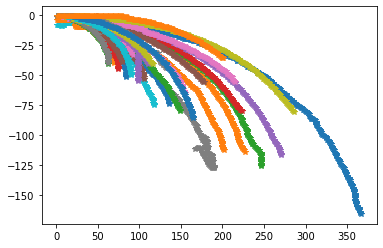

In [86]:
dff = pd.read_csv('names.csv')

print(dff)

name_arr = []
for Mati in dff['Main_Material'].dropna():
    for Main_Value in dff['Main_Value'].dropna():
        for Addition_Material in dff['Addition_Material'].dropna():
            for Percent_of_Addition_Material in dff['Percent_of_Addition_Material'].dropna():
                for Attempt in dff['Attempt'].dropna():
                    for Temperature in dff['Temperature'].dropna():
                        Val = int(Main_Value)
                        Mat = Mati
                        Add = Addition_Material
                        try:
                            Per = int(Percent_of_Addition_Material)
                        except:
                            Per = Percent_of_Addition_Material
                        Att = int(Attempt)
                        Tem = int(Temperature)
                        name = str(Val)+ "_" + Mat + "_" + Add + "_" + str(Per) + "_" + str(Att) +"_" + str(Tem)
                        
                        try:
                            h = pd.read_csv(name + '.csv')

                            h['x'] = -h['x']
                            h['y'] = -h['y']



                            mn = min(h['y'])
                            df2 = h[h['y']>mn+1].reset_index(drop=True)
                            df3 =  pd.DataFrame()
                            ln = len(df2)

                            cut_num = ln//2-30

                            df3['x'] = df2['x'].loc[0:cut_num].reset_index(drop=True) - df2['x'].loc[0]
                            df3['y']= df2['y'].loc[0:cut_num].reset_index(drop=True) - df2['y'].loc[0]
                    #         print('!!')

                            x1 = df3[df3['x']>0]['x']
                            y1 = df3[df3['x']>0]['y']
                            # plt.plot(x1, y1, marker = '*')

                            ct_angl, rat = angl_exp(x1, y1)
                    #         print(-ct_angl*180/np.pi)
                    #         print(rat)
                            # plt.plot(x, z)


                            plt.plot(x1, y1, linewidth = 0, marker = "*")
                            acur_rel = 0.07
                            acur_rel_xz = 0.07
                            df_approx = finds_b_approx(ct_angl, rat, coef_tbl, acur_rel, acur_rel_xz)


                            #finds optimized value of b
                            print(name)
                            print(df_approx)
                            B_ap = float(df_approx['b'].loc[len(df_approx)//2])
                            T_ap = float(df_approx['T_max'].loc[len(df_approx)//2])
                            x_ap, f_ap, z_ap = graf(B_ap, T_ap)


                            x2, y2 = normalize(x1, y1, z_ap)

                            print(x2)

                            dist_v = distance(B_ap, T_ap, np.array(x2), np.array(y2))

                            x2_inter = np.linspace(min(x2), max(x2), len(x_ap))
                            y2_inter = np.interp(x2_inter, x2, y2)

                            step = 0.01
                            dev = 0.3
                            B_arr = np.arange(B_ap-dev, B_ap+dev, step)

                            dist_res = pd.DataFrame()

                            print('a')
                            for b_i in B_arr:
                                dist_v_i = distance(b_i, T_ap, x2, y2)
                                dist_res_i = pd.DataFrame()
                                dist_res_i['dist'] = [dist_v_i]
                                dist_res_i['b'] = [b_i]
                                dist_res = dist_res.append(dist_res_i)

                            min_dist = dist_res[dist_res['dist'] == min(dist_res['dist'])]
                            B_pr = min_dist['b'].loc[0]
                            x_pr, f_pr, z_pr = graf(B_pr, T_ap)

                            V = volume_calc(x_pr, z_pr)
                            print(V)
                            po = 1000
                            c = (Val*1e-9/V)**(-2/3)
                            df_output = pd.DataFrame()
                            df_output["Main_Material"] = [Mat]
                            df_output["Main_Value"] =[Val]
                            df_output["Addition_Material"] = [Add]
                            df_output["Percent_of_Addition_Material"] =[ Per]
                            df_output["Attempt"] = [Att]
                            df_output["Temperature"] = [Tem]
                            df_output["x/z"] = [rat]
                            df_output["angle"] = [ct_angl]
                            df_output["b"] =[ B_pr]
                            df_output["Value"] = [V]
                            df_output["cap_const"] = [c]
                            df_output["sigma"] = [9.81*po/c]      
                            name_2 = name + "_" + "output"

                            df_output.to_csv(name_2 + ".csv")
                            print(df_output)
                        except Exception as e:
                            print('Ошибка:\n', traceback.format_exc())

                   

62.445761379968545
62.06896551724141
-1.7775229727134263


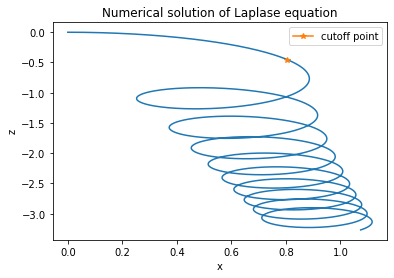

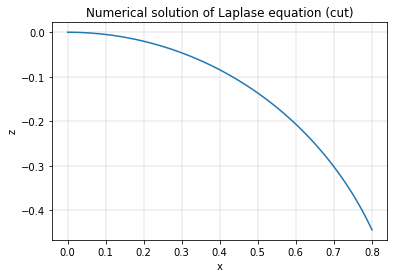

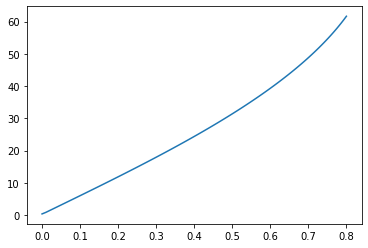

In [239]:
#plotting curve with point, denote the contact angle and cut curve 


ind = finds_angle(agl, ct_angl)



print(-agl[ind]*180/np.pi)
print(-ct_angl*180/np.pi)

plt.figure()
plt.plot(x, z)
plt.plot(x[ind], z[ind], marker = '*', label = "cutoff point")

plt.title("Numerical solution of Laplase equation")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()

x_cut = x[0:ind]
z_cut = z[0:ind]
agl_cut = agl[0:ind]

plt.figure()
plt.plot(x_cut, z_cut)
plt.title("Numerical solution of Laplase equation (cut)")
plt.xlabel("x")
plt.ylabel("z")
plt.grid(linewidth = 0.35)

plt.figure()
plt.plot(x_cut, -agl_cut*180/np.pi)

print(x[ind]/z[ind])

In [203]:
print(ct_angl)

-1.0833078115826877


In [205]:
#import coefficient table and adress to function, which finds b


coef_tbl = pd.read_csv('coef.csv')
acur_rel = 0.01
acur_rel_xz = 0.01
df_approx = finds_b_approx(ct_angl, rat, coef_tbl, acur_rel, acur_rel_xz)

print(df_approx)


   T_max  Unnamed: 0     angle    b       x/z
0   1.62      1662.0 -1.089878  0.5 -1.954607


In [206]:
#finds optimized value of b

print(df_approx)
B_ap = float(df_approx['b'].loc[0])
T_ap = float(df_approx['T_max'].loc[0])
x_ap, f_ap, z_ap = graf(B_ap, T_ap)


x2, y2 = normalize(x1, y1, z_ap)
dist_v = distance(B_ap, T_ap, x2, y2)

x2_inter = np.linspace(min(x2), max(x2), len(x_ap))
y2_inter = np.interp(x2_inter, x2, y2)

step = 0.001
dev = 0.1
B_arr = np.arange(B_ap-dev, B_ap+dev, step)

dist_res = pd.DataFrame()

for b_i in B_arr:
    dist_v_i = distance(b_i, T_ap, x2, y2)
    dist_res_i = pd.DataFrame()
    dist_res_i['dist'] = [dist_v_i]
    dist_res_i['b'] = [b_i]
    dist_res = dist_res.append(dist_res_i)

min_dist = dist_res[dist_res['dist'] == min(dist_res['dist'])]
print(min_dist)
B_pr = min_dist['b'].loc[0]


   T_max  Unnamed: 0     angle    b       x/z
0   1.62      1662.0 -1.089878  0.5 -1.954607
       dist     b
0  0.000139  0.49


-2.00053289741253
2.3778642898321913


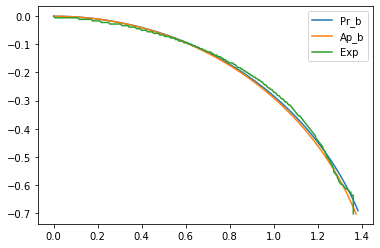

In [207]:
#plotting exp and theor curves

x_pr, f_pr, z_pr = graf(B_pr, T_ap)

V = volume_calc(x_pr, z_pr)

plt.plot(x_pr, z_pr, label = "Pr_b")

plt.plot(x_ap, z_ap, label = "Ap_b")
plt.plot(x2, y2, label = "Exp")


plt.legend()
print(x_pr[len(x_pr)-1]/z_pr[len(z_pr)-1])

print(V)

In [226]:
#constants
po = 1000
c = (Val_int*1e-9/V)**(-2/3)

In [229]:
df_output = pd.DataFrame()
df_output["Main_Material"] = [Mat]
df_output["Main_Value"] =[Val]
df_output["Addition_Material"] = [Add]
df_output["Percent_of_Addition_Material"] =[ Per]
df_output["Attempt"] = [Att]
df_output["Temperature"] = [Tem_int]
df_output["x/z"] = [rat]
df_output["angle"] = [ct_angl]
df_output["b"] =[ B_pr]
df_output["Value"] = [V]
df_output["cap_const"] = [c]
df_output["sigma"] = [9.81*po/c]

In [230]:
name_2 = name + "_" + "output"


df_output.to_csv(name_2 + ".csv")

In [44]:
data_coef.to_csv('coef.csv')

NameError: name 'data_coef' is not defined